In [8]:
#0.Importing required packages 
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sys
import traceback
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import stattools
from scipy import signal
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.pipelines.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from itertools import product
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5
import pandas as pd
import numpy as np
from datetime import datetime
from fedot.core.data.multi_modal import MultiModalData
# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

## Step 01: Preparing Data

In [3]:
#1.Reading Data 
energydata = pd.read_csv("./energydata_complete.csv")
#2.Creating subsamples
#2.1.Choosing colomns .. Target is T2,Tout
sample_energydata=energydata[[ 'date','T2', 'RH_2','T6','T_out']]
df_sample_colomn_energydata = pd.DataFrame(sample_energydata)

In [12]:
#timestamps to daily
df_sample_colomn_energydata['date']=pd.to_datetime(df_sample_colomn_energydata['date'])
df_sample_colomn_energydata['date']=df_sample_colomn_energydata['date'].dt.round('1d')  

## Step 02: Stationarity of a process (for mathematical expectation and variance)

In [48]:
def stationarity(col_name):
    #aggregation
    df_daily_T2=df_sample_colomn_energydata.groupby('date', as_index=False).agg({col_name: "avg"}) # median
    df_daily_T2=df_daily_T2.sort_values('date')
    #plotting
    plt.figure(figsize=(8, 6))
    plt.plot(df_daily_T2['date'],df_daily_T2[col_name])
    plt.xticks(rotation=45)
    plt.xlabel(u'Date', fontsize = 20)
    plt.ylabel(u'Sum', fontsize = 20)
    plt.title(col_name, fontsize = 20)
    # Testing , lower p-value --> more stationary
    result = smt.stattools.adfuller(df_daily_T2[col_name])
    print(col_name+': Augmented Dickey-Fuller test:\nStatistic value = %5f\np-value = %5f' % (result[0], result[1]))
    df_daily=df_daily_T2
    df_daily.index=pd.date_range(freq="m",start=df_daily_T2["date"][0],periods=len(df_daily_T2["date"]))
    #moving average
    result = seasonal_decompose((df_daily_T2[col_name]), model='additive')
    fig=result.plot()
    fig.set_figheight(6)
    fig.set_figwidth(14)
    plt.show()
    return df_daily_T2

In [50]:
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
        return pd.Series(diff)

### T2

T2: Augmented Dickey-Fuller test:
Statistic value = -3.582013
p-value = 0.006114


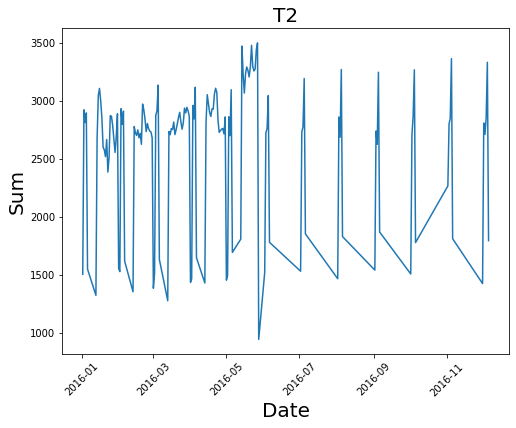

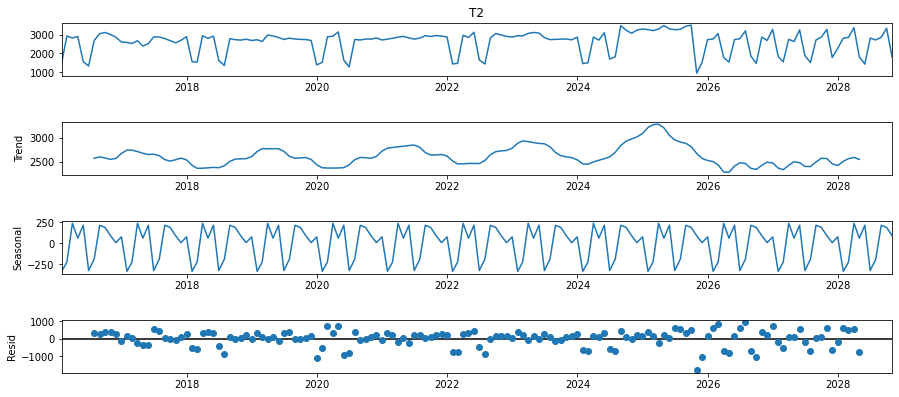

In [51]:
df_daily_T2=stationarity('T2')

RH_2: Augmented Dickey-Fuller test:
Statistic value = -4.391084
p-value = 0.000308


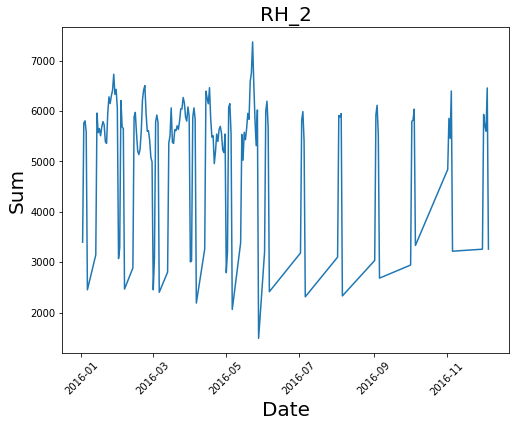

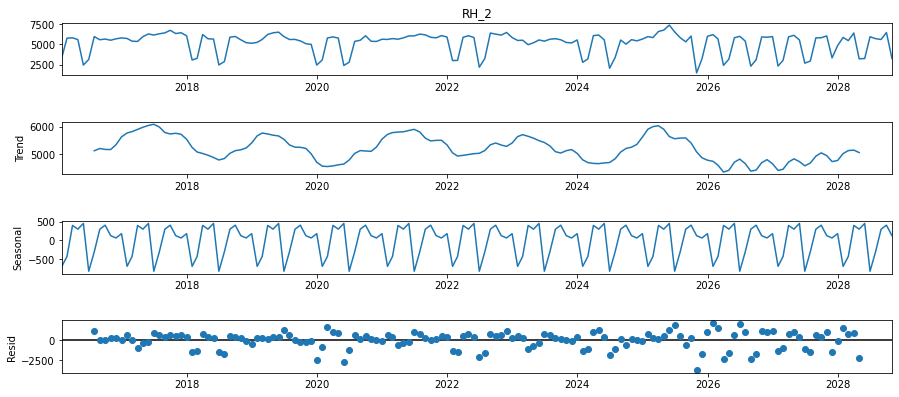

In [66]:
df_daily_RH2=stationarity('RH_2')

T6: Augmented Dickey-Fuller test:
Statistic value = -3.135783
p-value = 0.024016


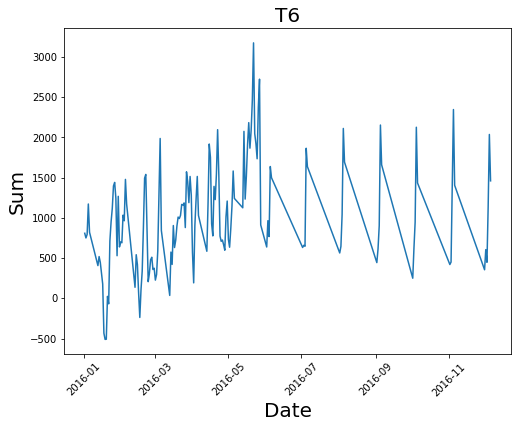

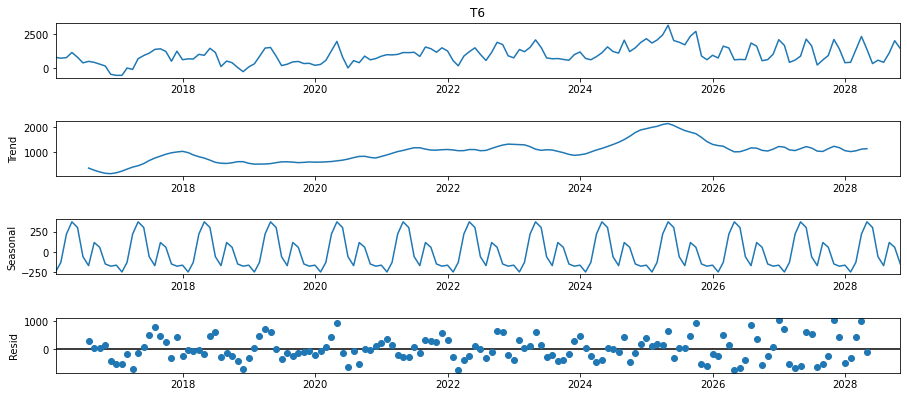

In [56]:
df_daily_T6=stationarity("T6")

T_out: Augmented Dickey-Fuller test:
Statistic value = -3.275590
p-value = 0.016005


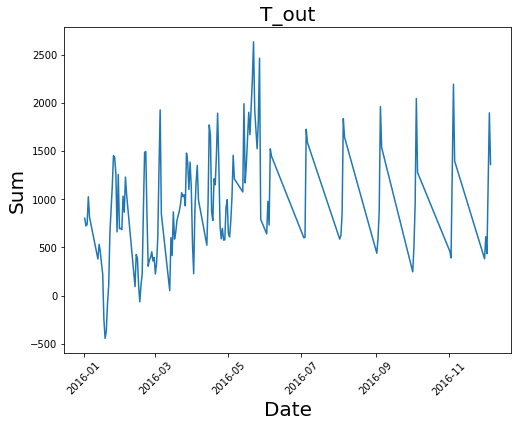

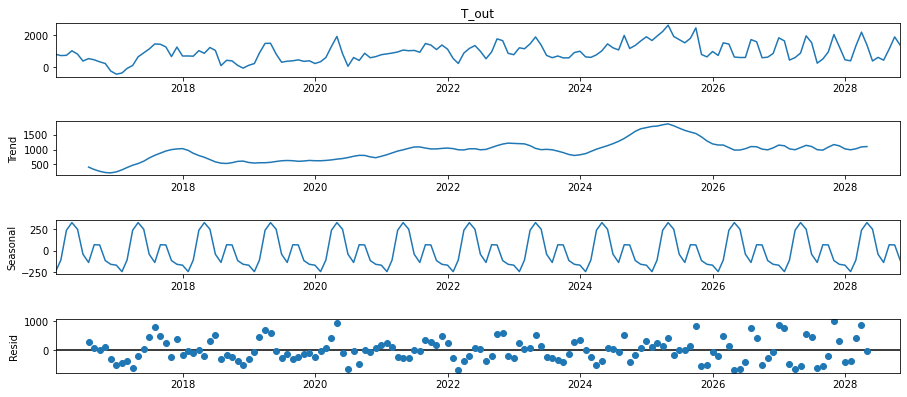

In [57]:
df_daily_Tout=stationarity("T_out")

## Step 03: Analyze covariance or correlation function for chosen target variables and mutual correlation functions among predictors and targets

### Covariance for Targets : T2 , T_out

Text(0.5, 1.0, 'T2')

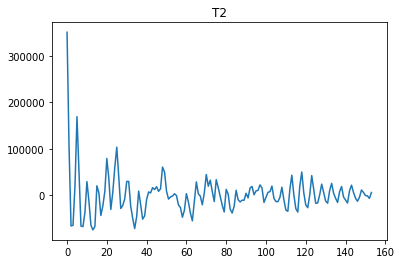

In [64]:
plt.plot(stattools.acovf(df_daily_T2['T2'],fft=False)) #autocovariance without window
plt.title("T2")

Text(0.5, 1.0, 'Tout')

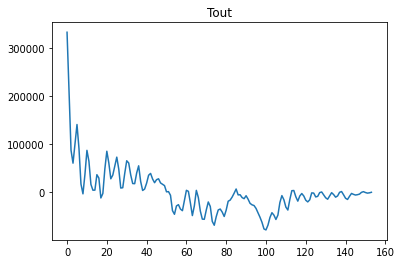

In [70]:
plt.plot(stattools.acovf(df_daily_Tout['T_out'],fft=False)) #autocovariance without window
plt.title("Tout")

### Mutual correlation functions among predictors and targets ?!

In [237]:
df_sample_colomn_energydata.corr()

,T2,RH_2,T6,T_out
T2,1.000000,-0.165610,0.801186,0.792247
RH_2,-0.165610,1.000000,-0.009670,0.033703
T6,0.801186,-0.009670,1.000000,0.974778
T_out,0.792247,0.033703,0.974778,1.000000


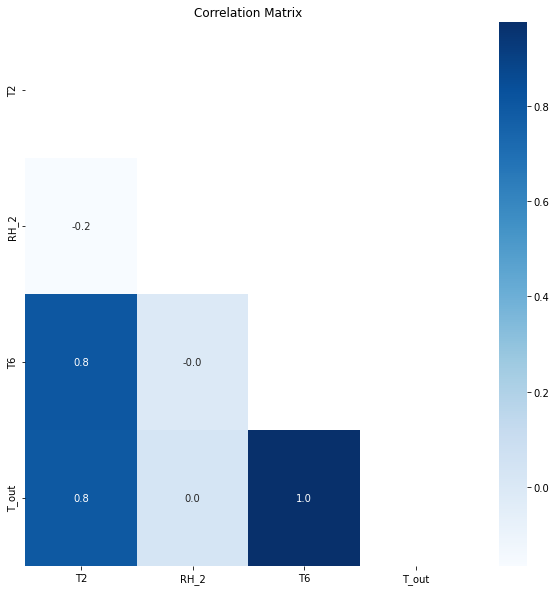

In [238]:
#Pair correlation coefficients, Correlation Matrix
fig, ax = plt.subplots(figsize=(10,10))
corr = df_sample_colomn_energydata[df_sample_colomn_energydata.columns[1:]].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True,  fmt='.1f',ax=ax, cmap = 'Blues')
plt.title('Correlation Matrix')
plt.show()

## Step 04: Filter high frequencies (noise) with chosen 2 filters for target variables

### T2 Filtering

In [141]:
# Data preperation
# Convert into numpy array first
time_series=np.array(df_daily_T2["T2"])
#FEDOT data preparation
# Define task - time series forecasting
# and forecast horizon 
task=Task (TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=25))
input_data = InputData(idx=np.arange(0, len(time_series)),
features=time_series, target=time_series,
task=task, data_type=DataTypesEnum.ts)

#### T2 Rolling Mean Filtering

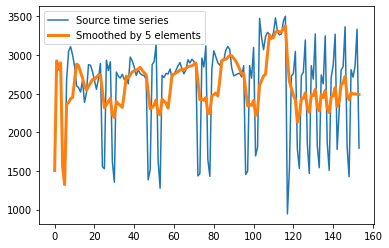

In [142]:
# Rolling mean window smoothing
smoothing_node = PrimaryNode('smoothing')
smoothing_node.custom_params = {'window_size': 6}
def node_fit_predict(node, input_data):
    """ Fit node and make prediction """
    node.fit(input_data)
    smoothed_output = node.predict(input_data)
    return smoothed_output
smoothed_output = node_fit_predict(smoothing_node, input_data)
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_output.idx, smoothed_output.predict, label='Smoothed by 5 elements', linewidth=3)
plt.legend()
plt.show()

#### T2 Gaussian Filter - compare results - summary plots

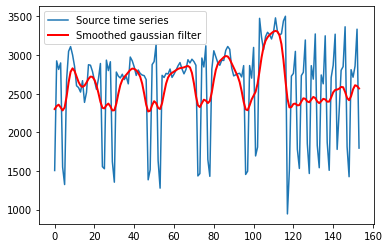

In [143]:
gaussian_node = PrimaryNode('gaussian_filter') 
gaussian_node.custom_params = {'sigma': 2}
smoothed_gaussian = node_fit_predict(gaussian_node, input_data)
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()
plt.show()

#### T2 both filters

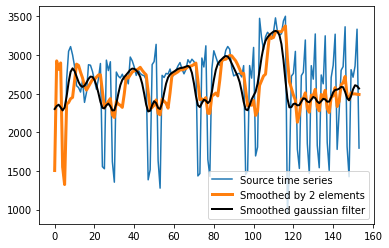

In [145]:
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(smoothed_output.idx, smoothed_output.predict, label='Smoothed by 2 elements', linewidth=3)
plt.plot(smoothed_gaussian.idx, smoothed_gaussian.predict, label='Smoothed gaussian filter', linewidth=2, c='black')
plt.legend()
plt.show()

### T_out Filtering

In [154]:
# Data preperation
# Convert into numpy array first
time_series_out=np.array(df_daily_Tout["T_out"])
#FEDOT data preparation
# Define task - time series forecasting
# and forecast horizon 
task=Task (TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=25))
input_data_out = InputData(idx=np.arange(0, len(time_series_out)),
features=time_series_out, target=time_series_out,
task=task, data_type=DataTypesEnum.ts)

#### T out: Rolling mean

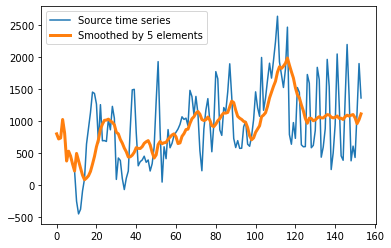

In [177]:
# Rolling mean window smoothing
smoothing_node_out = PrimaryNode('smoothing')
smoothing_node_out.custom_params = {'window_size': 10}
def node_fit_predict(node, input_data_out):
    """ Fit node and make prediction """
    node.fit(input_data_out)
    smoothed_output = node.predict(input_data_out)
    return smoothed_output
smoothed_output_out = node_fit_predict(smoothing_node_out, input_data_out)
plt.plot(input_data_out.idx, input_data_out.target, label='Source time series')
plt.plot(smoothed_output_out.idx, smoothed_output_out.predict, label='Smoothed by 5 elements', linewidth=3)
plt.legend()
plt.show()

#### Tout: Gaussian filter

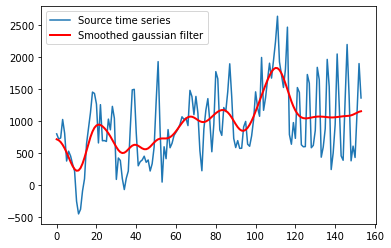

In [175]:
gaussian_node_out = PrimaryNode('gaussian_filter') 
gaussian_node_out.custom_params = {'sigma': 4}
smoothed_gaussian_out = node_fit_predict(gaussian_node_out, input_data_out)
plt.plot(input_data_out.idx, input_data_out.target, label='Source time series')
plt.plot(smoothed_gaussian_out.idx, smoothed_gaussian_out.predict, label='Smoothed gaussian filter', linewidth=2, c='red')
plt.legend()
plt.show()

#### T_out : both filters

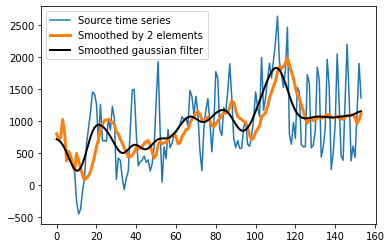

In [178]:
plt.plot(input_data_out.idx, input_data_out.target, label='Source time series')
plt.plot(smoothed_output_out.idx, smoothed_output_out.predict, label='Smoothed by 2 elements', linewidth=3)
plt.plot(smoothed_gaussian_out.idx, smoothed_gaussian_out.predict, label='Smoothed gaussian filter', linewidth=2, c='black')
plt.legend()
plt.show()

## Step 05 : Spectral density function with and without filtering
To analyze results after filtering

In [78]:
def Spec_Den_Fun(data,variable,name):
    window_size = 72
    blackman = signal.blackman(M=window_size)
    bartlett = signal.hanning(M=window_size)
    print(len(data))
    f, Pxx_den = signal.welch(variable, fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
    f_window, Pxx_den_window = signal.welch(variable, fs=1, window = blackman, nfft = 1000, scaling='spectrum')
    f_window_bart, Pxx_den_window_bart = signal.welch(variable, fs=1, window = bartlett, nfft = 1000, scaling='spectrum')
    plt.plot(f, Pxx_den, linewidth=4)
    plt.plot(f_window, Pxx_den_window)
    plt.plot(f_window_bart, Pxx_den_window_bart)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.xlim((0,0.16))
    plt.title("Spectual Density Function "+ name)
    plt.show()

#### T2

154


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  after removing the cwd from sys.path.


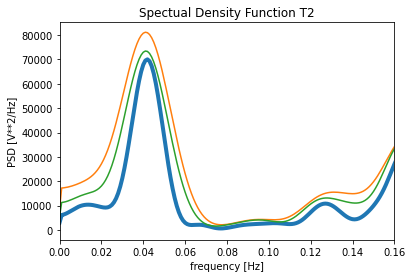

In [79]:
## Spectral density function T2 without filtering
Spec_Den_Fun(df_daily_T2,df_daily_T2["T2"],'T2')

154


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  after removing the cwd from sys.path.


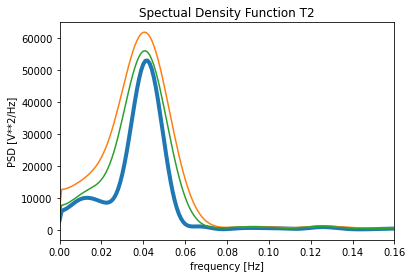

In [171]:
## Spectral density function T2 without filtering
Spec_Den_Fun(smoothed_gaussian.predict,smoothed_gaussian.predict,'T2')

#### T_out

C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  after removing the cwd from sys.path.


154


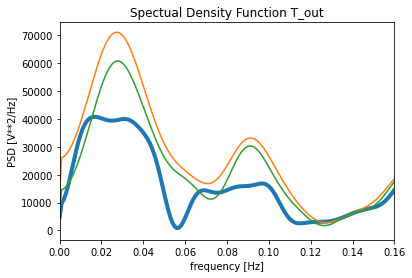

In [168]:
## Spectral density function Tout without filtering
Spec_Den_Fun(df_daily_Tout,df_daily_Tout["T_out"],'T_out')

154


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  after removing the cwd from sys.path.


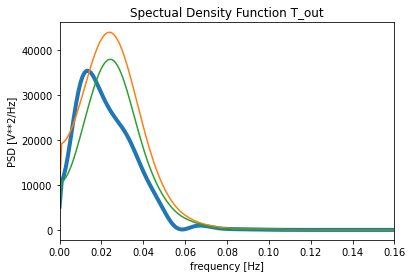

In [179]:
## Spectral density function Tout with filtering
Spec_Den_Fun(smoothed_gaussian_out.predict,smoothed_gaussian_out.predict,'T_out')

## Step 06: Built auto-regression model filtered and non-filtered data.
To analyze residual error and to define appropriate order of model.


#### T2 not filttered AR model
is it okay not to transform data before fitting to a model ?

In [189]:
# Convert into numpy array first
time_series_reg = np.array(df_daily_T2['T2'])

# Define task - time series forecasting
# and forecast horizon 
task_reg = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=36))

input_data_reg = InputData(idx=np.arange(0, len(time_series_reg)),
                       features=time_series_reg, target=time_series_reg,
                       task=task_reg, data_type=DataTypesEnum.ts)

In [192]:
train, test = train_test_data_setup(input_data_reg)

In [194]:
pipeline = Pipeline(PrimaryNode('ar'))
pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                        loss_params=None, input_data=train,
                                        iterations=500, timeout=5,
                                        cv_folds=3, validation_blocks=2)

Start pipeline tuning
Hyperparameters optimization start
Time series length too small for cross validation with 3 folds. Perform one fold validation
  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]Time series length too small for cross validation with 3 folds. Perform one fold validation
Time series length too small for cross validation with 3 folds. Perform one fold validation
Time series length too small for cross validation with 3 folds. Perform one fold validation
Time series length too small for cross validation with 3 folds. Perform one fold validation
Time series length too small for cross validation with 3 folds. Perform one fold validation
Time series length too small for cross validation with 3 folds. Perform one fold validation
Time series length too small for cross validation with 3 folds. Perform one fold validation
Time series length too small for cross validation with 3 folds. Perform one fold validation
Time series length too small for cross validation with 3 fol

Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False


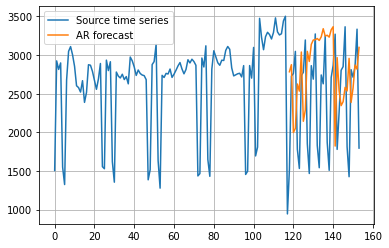

In [195]:
fitted_vals = pipeline.fit(train)
forecast = pipeline.predict(test)

plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='AR forecast')
plt.grid()
plt.legend()
plt.show()

#### T2 not filttered SARIMA and AIC model
need validation?

In [214]:
### other way
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print (u"Models to analyse by AIC:", len(parameters_list))

Models to analyse by AIC: 72


In [236]:
results = []
best_aic = float("inf")

for param in parameters_list:
    #try except for the case of wrong parameters
    try:
        model =sm.tsa.statespace.SARIMAX(np.array(df_daily_T2['T2']), order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #print wrong parameters and go on
    # AIC criteria:
    except BaseException as ex:
        # Get current system exception
        ex_type, ex_value, ex_traceback = sys.exc_info()

        # Extract unformatter stack traces as tuples
        trace_back = traceback.extract_tb(ex_traceback)

        # Format stacktrace
        stack_trace = list()

        for trace in trace_back:
            stack_trace.append("File : %s , Line : %d, Func.Name : %s, Message : %s" % (trace[0], trace[1], trace[2], trace[3]))

        print("Exception type : %s " % ex_type.__name__)
        print("Exception message : %s" %ex_value)
        print("Stack trace : %s" %stack_trace)
    aic = model.aic
    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [223]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
65  (5, 2, 1, 0)  2177.324438
51  (4, 1, 1, 0)  2180.173958
61  (5, 0, 1, 0)  2180.786909
55  (4, 3, 1, 0)  2183.063880
57  (4, 4, 1, 0)  2183.077857


In [224]:
print(best_model.summary())


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  154
Model:             SARIMAX(5, 1, 2)x(1, 1, [], 12)   Log Likelihood               -1079.662
Date:                             Wed, 24 Nov 2021   AIC                           2177.324
Time:                                     07:51:51   BIC                           2203.863
Sample:                                          0   HQIC                          2188.109
                                             - 154                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0432      0.110      0.394      0.694      -0.172       0.258
ar.L2         -0.1529      

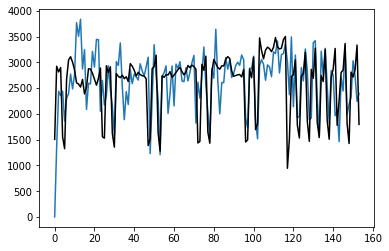

In [229]:
plt.plot(best_model.fittedvalues)
plt.plot(df_daily_T2['T2'],color='black')

#### T2 filttered

## Step 07: Build model in a form of linear dynamical system, using chosen predictors.
To analyze residual error and to define appropriate order of model.

### T2 based on RH2 and T6

In [5]:
# Data preprocessing for FEDOT
def wrap_into_input(forecast_length, feature_time_series, target_time_series):
    """ Convert data for FEDOT framework """
    task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=forecast_length))
    
    input_data = InputData(idx=np.arange(0, len(target_time_series)),
                           features=feature_time_series, target=target_time_series,
                           task=task, data_type=DataTypesEnum.ts)
    
    return input_data
forecast_length = 200
ts_1 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=np.array(df_sample_colomn_energydata['T2']),
                       target_time_series=np.array(df_sample_colomn_energydata['T6']))

ts_2 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=np.array(df_sample_colomn_energydata['T2']),
                       target_time_series=np.array(df_sample_colomn_energydata['RH_2']))

dataset = MultiModalData({
    'data_source_ts/Hsig': ts_1,
    'data_source_ts/RTpeak': ts_2
})

In [6]:
train, test = train_test_data_setup(dataset)

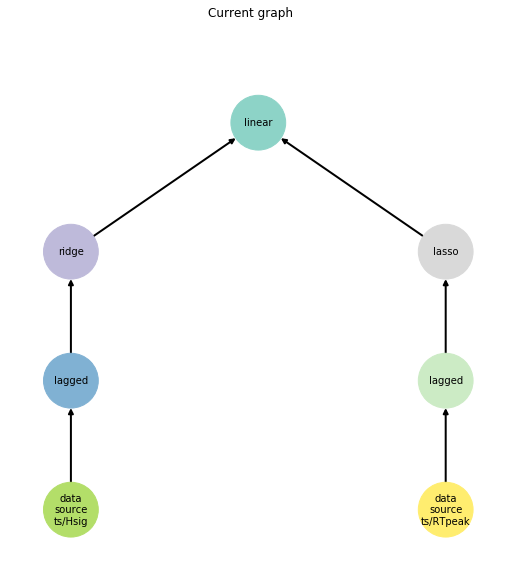

In [10]:
def create_multisource_pipeline():
    """ Generate pipeline with several data sources """
    node_source_1 = PrimaryNode('data_source_ts/Hsig')
    node_source_2 = PrimaryNode('data_source_ts/RTpeak')

    node_lagged_1 = SecondaryNode('lagged', nodes_from=[node_source_1])
    node_lagged_1.custom_params = {'window_size': 150}
    node_lagged_2 = SecondaryNode('lagged', nodes_from=[node_source_2])
      
    node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged_1])
    node_lasso = SecondaryNode('lasso', nodes_from=[node_lagged_2])
    
    node_final = SecondaryNode('linear', nodes_from=[node_ridge, node_lasso])
    pipeline = Pipeline(node_final)
    return pipeline

pipeline = create_multisource_pipeline()
pipeline.show()

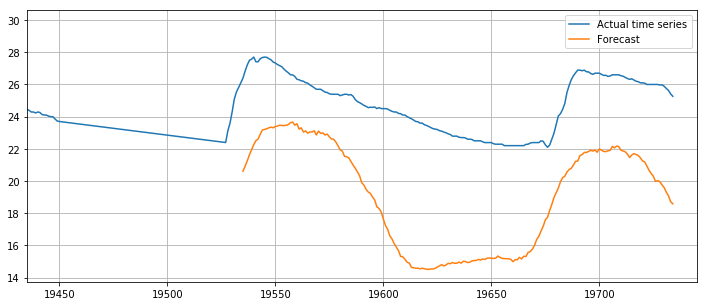

In [14]:
pipeline.fit(train)
forecast = pipeline.predict(test)

train_length = len(df_sample_colomn_energydata['T2']) - forecast_length

plt.plot(df_sample_colomn_energydata['T2'], label='Actual time series')
plt.plot(np.arange(train_length, train_length + forecast_length), 
         np.ravel(forecast.predict), label='Forecast')
plt.xlim(train_length - 100, len(df_sample_colomn_energydata['T2']) + 10)
plt.legend()
plt.grid()
plt.show()

### T_out based on RH_2 and T6

In [16]:
Tout_ts_1 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=np.array(df_sample_colomn_energydata['T_out']),
                       target_time_series=np.array(df_sample_colomn_energydata['T6']))

T6outts_2 = wrap_into_input(forecast_length=forecast_length, 
                       feature_time_series=np.array(df_sample_colomn_energydata['T_out']),
                       target_time_series=np.array(df_sample_colomn_energydata['RH_2']))

dataset_out = MultiModalData({
    'data_source_ts/Hsig': ts_1,
    'data_source_ts/RTpeak': ts_2
})

In [17]:
train_out, test_out = train_test_data_setup(dataset_out)

In [18]:
pipeline_out = create_multisource_pipeline()

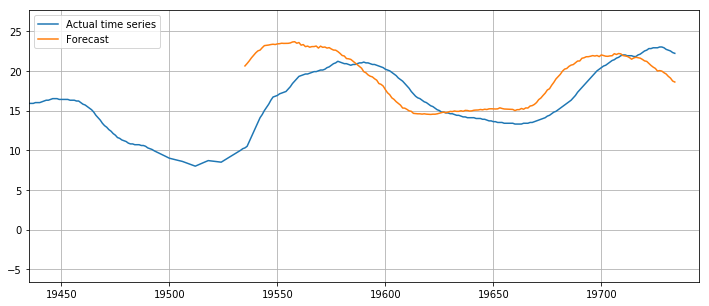

In [20]:
forecast_length_out=200
pipeline_out.fit(train_out)
forecast_out = pipeline.predict(test_out)

train_length_out = len(df_sample_colomn_energydata['T_out']) - forecast_length_out

plt.plot(df_sample_colomn_energydata['T_out'], label='Actual time series')
plt.plot(np.arange(train_length_out, train_length_out + forecast_length_out), 
         np.ravel(forecast_out.predict), label='Forecast')
plt.xlim(train_length_out - 100, len(df_sample_colomn_energydata['T_out']) + 10)
plt.legend()
plt.grid()
plt.show()